<a href="https://colab.research.google.com/github/DhafinRA/ML-Upatik/blob/main/Food_Classification_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT DEPENDENCIES

In [116]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import ResNet50V2
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [117]:
#HYPERPARAMETER

EPOCHS = 20
LOSS = CategoricalCrossentropy()
OPTIMIZERS = Adam()
input_shape = (224,224,3)
train_dir = "Image Eye\Train"
test_dir = "Image Eye\Test"

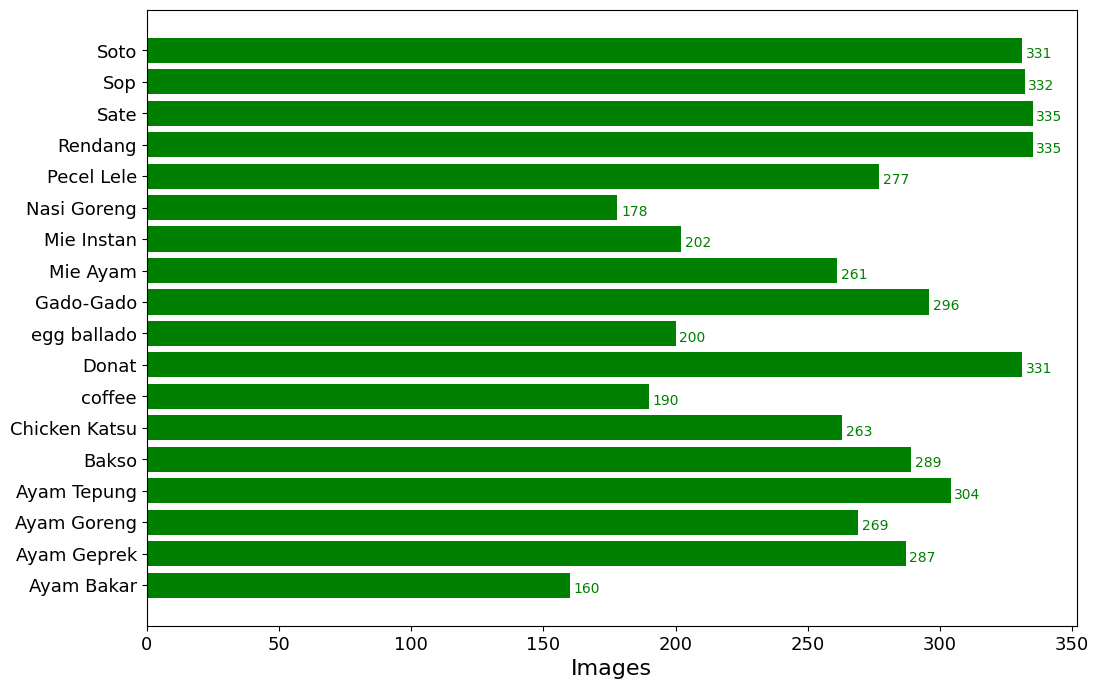

In [118]:
data=dict()

for i in os.listdir(train_dir):
    sub_dir=os.path.join(train_dir,i)
    count=len(os.listdir(sub_dir))
    data[i]=count
    
  
keys = data.keys()
values = data.values()

colors=["red" if x<= 150 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Labeling Photo Using ImageDataGenerator

In [119]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Show All Classes

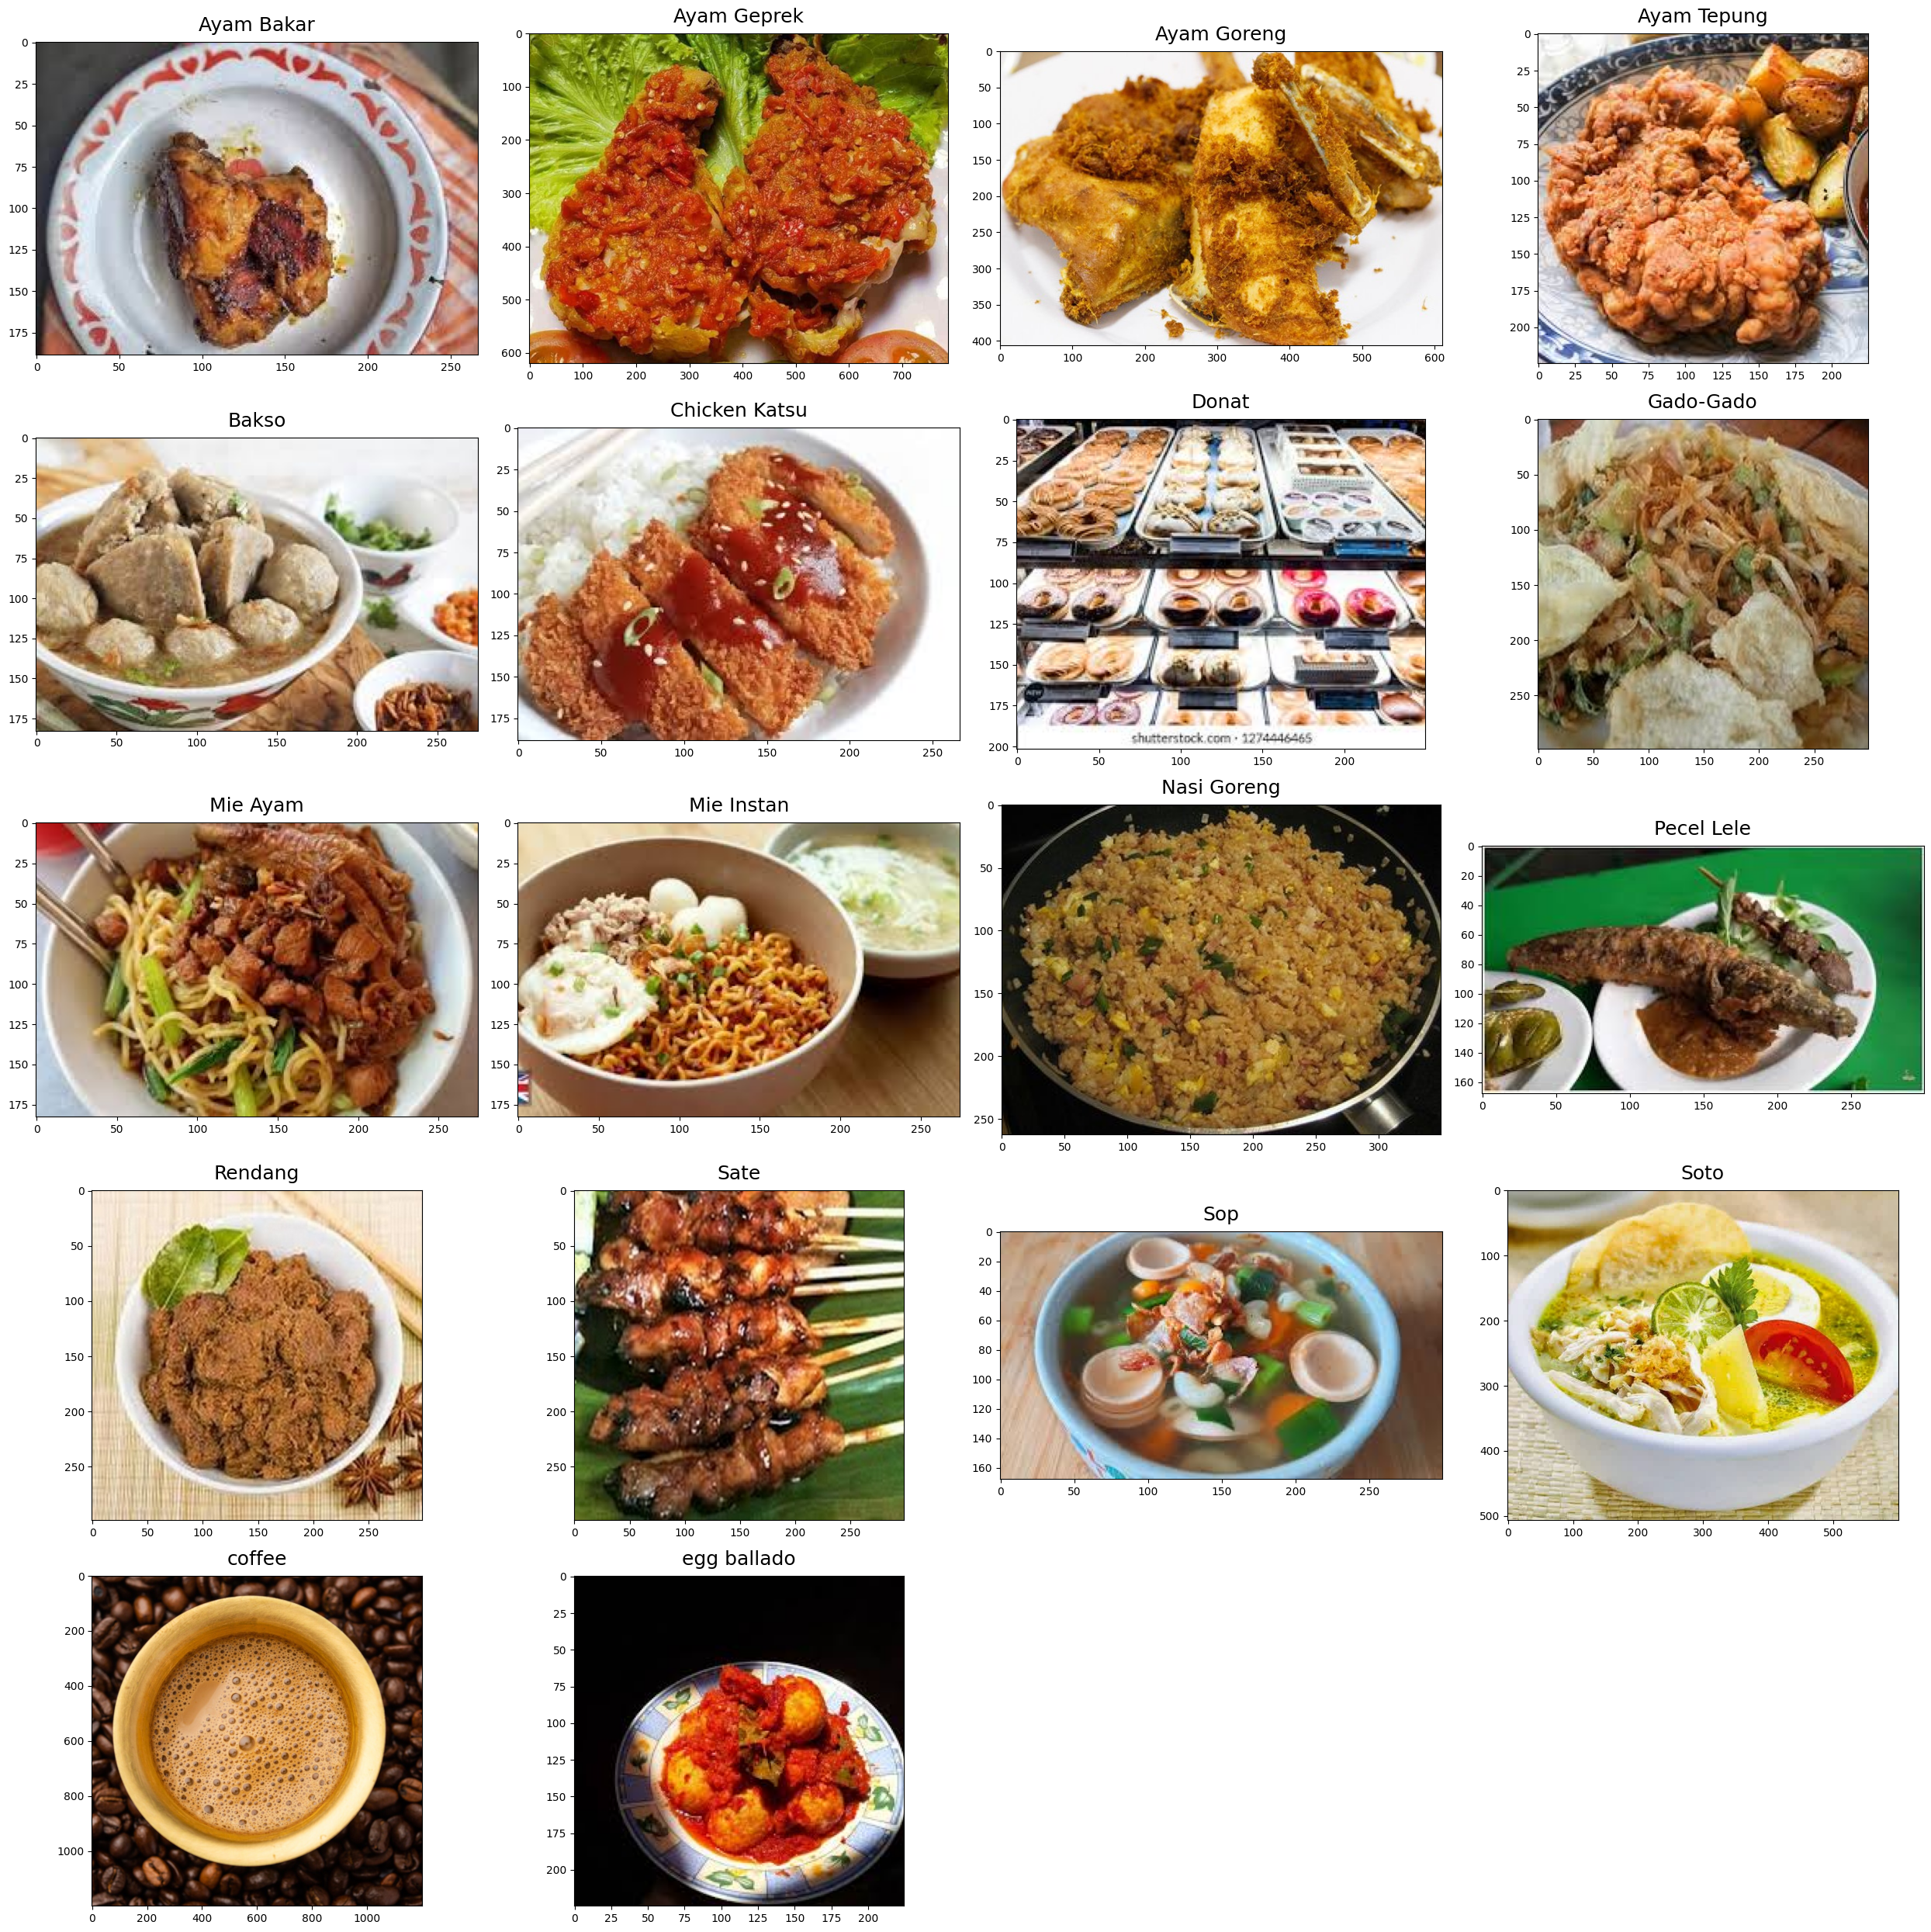

In [120]:
images = []
labels = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    labels.append(category)

plt.tight_layout()

In [121]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(150, 150),
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 4838 images belonging to 18 classes.
Found 1262 images belonging to 18 classes.


Making Callbacks for Training

In [122]:
# class myCallback(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs={}):
#             if (logs.get('val_accuracy') > 0.83 and logs.get('accuracy')>0.83):
#                 print('\naccuracy and validation accuracy reached 83%,so cancelling training!')
#                 self.model.stop_training = True
                
# callbacks = myCallback()

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model/model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    restore_best_weights = True,
)

In [123]:
resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

total_layers = len(resnet.layers)

fn_layers = total_layers - round(int(0.8 * total_layers))
# Freezing the Base Layer
for layer in resnet.layers[:fn_layers]:
    layer.trainable = False

print("trainable layers: \n")
for i in resnet.layers[fn_layers:]:
    print(i.name)

trainable layers: 



Making Model

In [124]:
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(18,activation='softmax')
])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_13  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_36 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_37 (Dense)            (None, 18)                18450     
                                                                 
Total params: 25,681,426
Trainable params: 25,427,218
Non-trainable params: 254,208
___________________________________

In [125]:
# model.load_weights('Weights/weight')
model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_generator,epochs=EPOCHS,validation_data=test_generator)

Epoch 1/20
484/484 [==============================] - 43s 84ms/step - loss: 2.3199 - accuracy: 0.2569 - val_loss: 4.7927 - val_accuracy: 0.1331
Epoch 2/20
484/484 [==============================] - 39s 80ms/step - loss: 1.7518 - accuracy: 0.4283 - val_loss: 9.7226 - val_accuracy: 0.1704
Epoch 3/20
484/484 [==============================] - 37s 76ms/step - loss: 1.4907 - accuracy: 0.5151 - val_loss: 5.4712 - val_accuracy: 0.2417
Epoch 4/20
484/484 [==============================] - 37s 77ms/step - loss: 1.2944 - accuracy: 0.5757 - val_loss: 4.5521 - val_accuracy: 0.2536
Epoch 5/20
484/484 [==============================] - 38s 79ms/step - loss: 1.2010 - accuracy: 0.6112 - val_loss: 5.6347 - val_accuracy: 0.1989
Epoch 6/20
484/484 [==============================] - 40s 82ms/step - loss: 1.0980 - accuracy: 0.6453 - val_loss: 4.6569 - val_accuracy: 0.2971
Epoch 7/20
484/484 [==============================] - 41s 84ms/step - loss: 1.0345 - accuracy: 0.6627 - val_loss: 5.2421 - val_accuracy:

In [126]:
model.save_weights('Weights/weight')

RESULTS

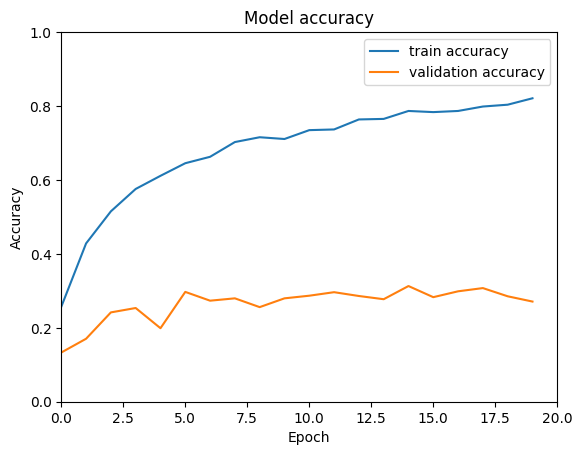

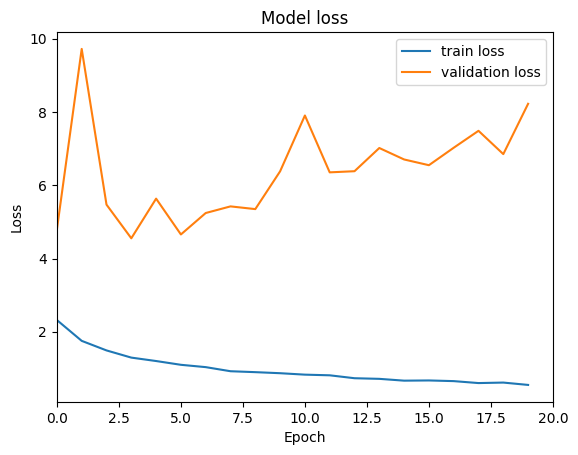

In [127]:
def plot_accuracy(history,x_axis=EPOCHS):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xlim(0,EPOCHS)
    plt.ylim(0,1)
    plt.legend(loc='best')
    plt.show()

def plot_loss(history,x_axis=EPOCHS):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim(0,EPOCHS)
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [128]:
predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

631/631 [==============================] - 8s 12ms/step


In [129]:
loss, acc = model.evaluate(test_generator)
print("Test accuracy:", round(acc,4)*100,'%', "\nLoss value:",loss)

631/631 [==============================] - 9s 14ms/step - loss: 8.2242 - accuracy: 0.2710
Test accuracy: 27.1 % 
Loss value: 8.2241849899292


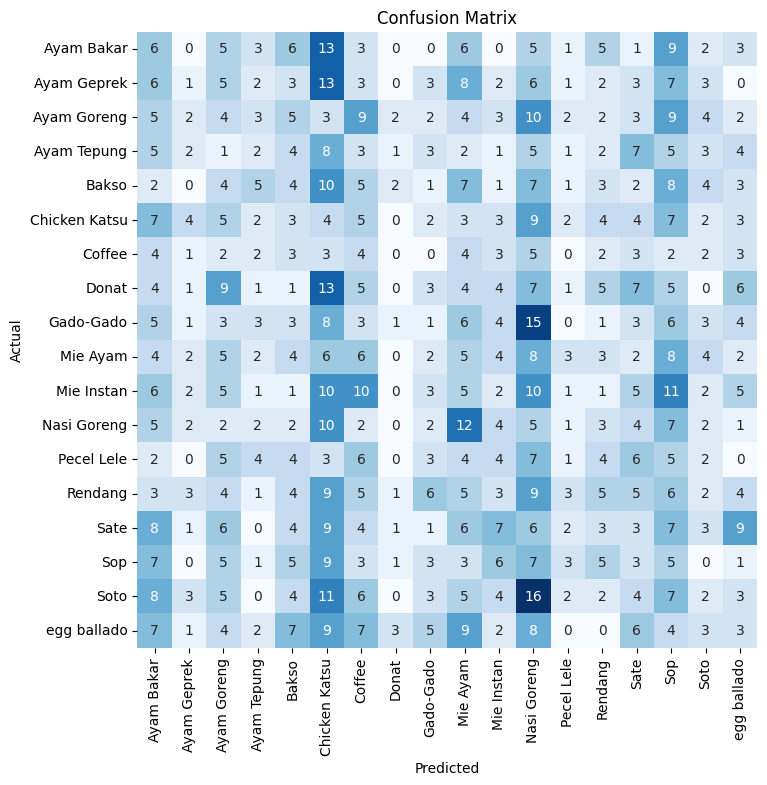

In [130]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(18) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(18) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [131]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

   Ayam Bakar       0.06      0.09      0.07        68
  Ayam Geprek       0.04      0.01      0.02        68
  Ayam Goreng       0.05      0.05      0.05        74
  Ayam Tepung       0.06      0.03      0.04        59
        Bakso       0.06      0.06      0.06        69
Chicken Katsu       0.03      0.06      0.04        69
       Coffee       0.04      0.09      0.06        43
        Donat       0.00      0.00      0.00        76
    Gado-Gado       0.02      0.01      0.02        70
     Mie Ayam       0.05      0.07      0.06        70
   Mie Instan       0.04      0.03      0.03        80
  Nasi Goreng       0.03      0.08      0.05        66
   Pecel Lele       0.04      0.02      0.02        60
      Rendang       0.10      0.06      0.08        78
         Sate       0.04      0.04      0.04        80
          Sop       0.04      0.07      0.05        67
         Soto    